## Code

### Libs

In [13]:
shouldUnzipData = True
combiner = lambda *cm: zip(*cm)

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pandas import read_csv

if shouldUnzipData:
  from zipfile import ZipFile

### Structs

In [15]:
class Node:
    def __init__(self):
        self.l = None
        self.r = None

        self.y = None
        self.f = None
        self.b = None

In [16]:
class DT:
    def __init__(self, h=None):
        self.X = None
        self.y = None

        self.root = None
        self.h = h

        self.n = None
        self.m = None
        self.k = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n = len(X)
        self.m = len(X[0])
        self.k = max(y) + 1
        self.root = Node()
        self.__build(self.root, range(self.n), -1, 0)

    def predict(self, x, node=None):
        if node is None:
            node = self.root
        if node.l is None:
            return node.y
        if x[node.f] < node.b:
            return self.predict(x, node.l)
        return self.predict(x, node.r)

    def __build(self, T, objects, parent_class, d):
        if len(objects) == 0:
            T.y = parent_class
            return
        ys = [0] * self.k
        for i in objects:
            ys[self.y[i]] += 1
        max_y = np.argmax(ys)
        if ys[max_y] == len(objects) or self.h is not None and d == self.h:
            T.y = max_y
            return
        best_gini = 0
        best_T1, best_T2 = [], []
        for f in range(self.m):
            init_objs = sorted(objects, key=lambda obj: self.X[obj][f])
            _T1 = []
            _T2 = init_objs
            l, r = [0] * self.k, [0] * self.k
            T1 = []
            T2 = _T2
            b = -1e9
            for i in init_objs:
                r[self.y[i]] += 1
            sum_l = 0
            sum_r = sum([x * x for x in r])
            cur_gini = gini(sum_l, sum_r, len(_T1), len(_T2))
            for j in range(len(init_objs)):
                i = init_objs[j]
                sum_r += (r[self.y[i]] - 1) ** 2 - r[self.y[i]] ** 2
                r[self.y[i]] -= 1
                sum_l += (l[self.y[i]] + 1) ** 2 - l[self.y[i]] ** 2
                l[self.y[i]] += 1
                _T1.append(_T2[0])
                _T2 = _T2[1:]
                tmp = gini(sum_l, sum_r, len(_T1), len(_T2))
                if cur_gini < tmp or \
                        np.isclose(cur_gini, tmp) and abs(len(_T1) - len(_T2)) < abs(len(T1) - len(T2)):
                    cur_gini = tmp
                    T1 = list(_T1)
                    T2 = _T2
                    b = (self.X[i][f] + self.X[init_objs[j + 1]][f]) / 2 if j + 1 < len(init_objs) else 1e9
            if best_gini < cur_gini:
                best_gini = cur_gini
                T.f = f
                T.b = b
                best_T1 = T1
                best_T2 = T2

        T.l = Node()
        self.__build(T.l, best_T1, max_y, d + 1)
        T.r = Node()
        self.__build(T.r, best_T2, max_y, d + 1)

In [17]:
class RF:
    def __init__(self, has_random_objects=False, has_random_features=False):
        self.has_random_objects = has_random_objects
        self.has_random_features = has_random_features
        
        self.trees = None
        self.k = 0

    def fit(self, X, y, count_trees=10):
        self.trees = []
        for _ in range(count_trees):
            tree = DT()
            final_X, final_y = X, y
            if self.has_random_features:
                final_X = random_features(final_X, int(np.sqrt(len(X[0]))))
            if self.has_random_objects:
                final_X, final_y = random_objects(final_X, final_y, int(np.sqrt(len(X))))
            tree.fit(final_X, final_y)
            self.k = max(self.k, tree.k)
            self.trees.append(tree)

    def predict(self, x):
        ys = [0] * self.k
        for tree in self.trees:
            ys[tree.predict(x)] += 1
        return int(np.argmax(ys))

### Helpers

In [18]:
gini = lambda sum_l, sum_r, L, R: (sum_l / L if L > 0 else 0) + (sum_r / R if R > 0 else 0)

In [19]:
def random_objects(X, y, subset_size):
    n = len(X)
    new_X, new_y = [], []
    for _ in range(subset_size):
        i = random.randint(0, n - 1)
        new_X.append(X[i])
        new_y.append(y[i])
    return new_X, new_y

In [20]:
def random_features(X, subset_size):
    m = len(X[0])
    indices = []
    for _ in range(subset_size):
        indices.append(random.randint(0, m - 1))
    return [[x[i] for i in indices] for x in X]

### Data Process

In [21]:
def getDatasetPartName(n):
    return '' + str(n).zfill(2)

In [22]:
if shouldUnzipData:
    with ZipFile('DT_csv.zip', 'r') as zip_file:
        zip_file.extractall()
        print('ok')
else:
    print('didn\'t extract')

ok


In [23]:
def read_dataset(file_name):
    return read_csv(file_name, usecols=lambda x: x != 'y').values.tolist(), read_csv(file_name)['y'].values.tolist()


def read_train(i):
    return read_dataset(getDatasetPartName(i) + '_train.csv')


def read_test(i):
    return read_dataset(getDatasetPartName(i) + '_test.csv')

In [24]:
train_data = [read_train(i+1) for i in range(21)]
test_data = [read_test(i+1) for i in range(21)]
train_X_list, train_y_list = [x[0] for x in train_data], [[y - 1 for y in x[1]] for x in train_data]
test_X_list, test_y_list = [x[0] for x in test_data], [[y - 1 for y in x[1]] for x in test_data]

In [25]:
forest_size = 100
datasets = np.array(range(21))
tree_f_scores = []
random_objects_forest_f_scores = []
random_features_forest_f_scores = []

### Scoring Helpers

In [26]:
def test_classifier(classifier, test_X, test_y):
    k = max(classifier.k, max(test_y) + 1)
    cm = [[0] * k for _ in range(k)]
    for i in range(len(test_X)):
        cm[test_y[i]][classifier.predict(test_X[i])] += 1
    return f_score(cm, k)

In [27]:
def f_score(cm, k):
    row_sum = [sum(row) for row in cm]
    column_sum = [sum(column) for column in combiner(*cm)]

    macro_precision = [0 if column_sum[i] < 1e-6 else cm[i][i] / column_sum[i] for i in range(k)]
    macro_recall = [0 if row_sum[i] < 1e-6 else cm[i][i] / row_sum[i] for i in range(k)]

    precision_avg = weighted_average(macro_precision, row_sum)
    recall_avg = weighted_average(macro_recall, row_sum)
    return 0 if precision_avg < 1e-6 and recall_avg < 1e-6 else 2 * precision_avg * recall_avg / (precision_avg + recall_avg)

In [28]:
def weighted_average(v, weights):
    v_sum = sum(v[i] * weights[i] for i in range(len(v)))
    w_sum = sum(weights[i] for i in range(len(v)))
    return 0 if v_sum < 1e-6 or w_sum < 1e-6 else v_sum / w_sum

### Process

#### Tree

In [29]:
heights = []
for dataset_index in range(21):
    best_h = 0
    best_f_score = 0
    for h in range(1, 21):
        tree = DT(h)
        tree.fit(train_X_list[dataset_index], train_y_list[dataset_index])
        cur_f_score = test_classifier(tree, test_X_list[dataset_index], test_y_list[dataset_index])
        if best_f_score < cur_f_score:
            best_f_score = cur_f_score
            best_h = h
    heights.append(best_h)
    print('dataset №%d :: best h = %d, with f score = %f' % (dataset_index + 1, best_h, best_f_score))

dataset №0 :: best h = 3, with f score = 0.999486
dataset №1 :: best h = 9, with f score = 0.648926
dataset №2 :: best h = 1, with f score = 1.000000
dataset №3 :: best h = 5, with f score = 0.992685
dataset №4 :: best h = 1, with f score = 0.995785
dataset №5 :: best h = 3, with f score = 0.992329
dataset №6 :: best h = 3, with f score = 0.996281
dataset №7 :: best h = 2, with f score = 0.997990
dataset №8 :: best h = 5, with f score = 0.812556
dataset №9 :: best h = 4, with f score = 0.994007
dataset №10 :: best h = 1, with f score = 0.999196
dataset №11 :: best h = 7, with f score = 0.868610
dataset №12 :: best h = 7, with f score = 0.624002
dataset №13 :: best h = 6, with f score = 0.961454
dataset №14 :: best h = 1, with f score = 1.000000
dataset №15 :: best h = 1, with f score = 1.000000
dataset №16 :: best h = 7, with f score = 0.817051
dataset №17 :: best h = 5, with f score = 0.936440
dataset №18 :: best h = 7, with f score = 0.815744
dataset №19 :: best h = 7, with f score =

#### Forest

In [30]:
for dataset_index in tqdm(datasets):
    tree = DT(10)
    random_objects_forest = RF(has_random_objects=True)
    random_features_forest = RF(has_random_features=True)
    
    tree.fit(train_X_list[dataset_index], train_y_list[dataset_index])
    random_objects_forest.fit(train_X_list[dataset_index], train_y_list[dataset_index], forest_size)
    random_features_forest.fit(train_X_list[dataset_index], train_y_list[dataset_index], forest_size)
    
    tree_f_scores.append(test_classifier(tree, test_X_list[dataset_index], test_y_list[dataset_index]))    
    random_objects_forest_f_scores.append(
        test_classifier(random_objects_forest, test_X_list[dataset_index], test_y_list[dataset_index]))
    random_features_forest_f_scores.append(
        test_classifier(random_features_forest, test_X_list[dataset_index], test_y_list[dataset_index]))

100%|██████████| 21/21 [4:25:43<00:00, 759.21s/it]


### Vuzualization

In [43]:
def draw_tree_res():
    global heights
    indices = sorted(range(len(heights)), key=lambda i: heights[i])
    vars = [indices[0], indices[len(indices) // 2], indices[-1]]
    titles = ['min optimal h', 'mid optimal h', 'max optimal h']
    for i in range(3):
        hs = range(1, 21)
        train_f_scores, test_f_scores = [], []
        dataset_index = vars[i]
        title = titles[i]
        for h in hs:
            tree = DT(h)
            tree.fit(train_X_list[dataset_index], train_y_list[dataset_index])
            
            train_f_scores.append(test_classifier(tree, train_X_list[dataset_index], train_y_list[dataset_index]))
            test_f_scores.append(test_classifier(tree, test_X_list[dataset_index], test_y_list[dataset_index]))
        
        plt.title(title)
        plt.plot(hs, train_f_scores, label='train dataset')
        plt.plot(hs, test_f_scores, label='test dataset')
        plt.xlabel('tree h')
        plt.ylabel('f score')
        plt.legend()
        plt.show()

In [32]:
def draw_forest_res():
    width = 0.2
    plt.bar(datasets - width, tree_f_scores, label='One tree', width=width)
    plt.bar(datasets, random_objects_forest_f_scores, label='Random objects', width=width)
    plt.bar(datasets + width, random_features_forest_f_scores, label='Random features', width=width)
    plt.xlabel('dataset')
    plt.ylabel('f score')
    plt.legend()
    plt.show()

## Results

### Tree

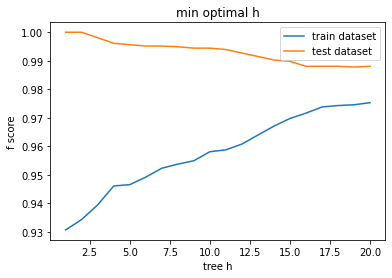

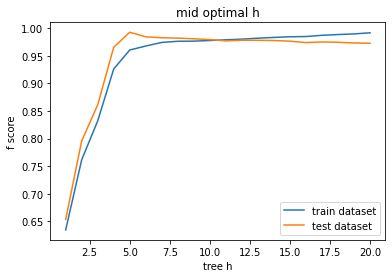

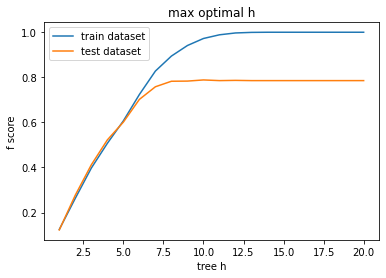

In [44]:
draw_tree_res()

### Forest

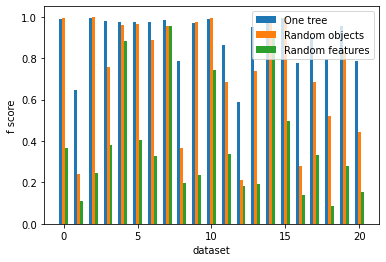

In [33]:
draw_forest_res()